# Installation Notes

Clone the openeo_dedl_plugin repo and install the `env_installation_insula.sh` and select the relevant kernel to run this notebook

In [1]:
import destinelab as deauth

In [2]:
import requests
import json
import os
import zipfile
import datetime
import shutil
from getpass import getpass

In [3]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  sdhinakaran@eurac.edu
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


In [4]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID = "EO.EUM.DAT.MSG.HRSEVIRI" 
response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
    "collections": [COLLECTION_ID],
    "datetime": "2024-09-06T08:00:00Z/2025-05-07T00:00:00Z"
})
response.json()["features"][0]

{'type': 'Feature',
 'assets': {'EOPMetadata.xml': {'title': 'EOPMetadata.xml',
   'type': 'Link',
   'href': 'https://hda-download.lumi.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.MSG.HRSEVIRI/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA/EOPMetadata.xml',
   'mediaType': 'application/xml',
   'roles': ['metadata'],
   'alternate': {'origin': {'title': 'EOPMetadata.xml',
     'type': 'Link',
     'href': 'https://api.eumetsat.int/data/download/1.0.0/collections/EO%3AEUM%3ADAT%3AMSG%3AHRSEVIRI/products/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA/entry?name=EOPMetadata.xml',
     'mediaType': 'application/xml',
     'roles': ['metadata']}}},
  'manifest.xml': {'title': 'manifest.xml',
   'type': 'Link',
   'href': 'https://hda-download.lumi.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.MSG.HRSEVIRI/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA/manifest.xml',
   'mediaType': 'application/xml',
   'roles': ['metadata'],
   'alternate': {'origin': {'title

In [5]:
from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

In [6]:
from pathlib import Path
from tqdm import tqdm
import requests

# Ensure ~/data exists
data_dir = Path.home() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

assets = ["downloadLink"]

for asset in assets:
    download_url = product["assets"][asset]["href"]
    print(download_url)

    # Correct filename construction
    filename = f"{product['id']}.zip"
    output_path = data_dir / filename

    print(f"Downloading → {output_path}")

    response = requests.get(download_url, headers=auth_headers, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with tqdm(
        total=total_size,
        unit="B",
        unit_scale=True,
        desc=filename,
    ) as progress_bar:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    progress_bar.update(len(chunk))

https://hda-download.lumi.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.MSG.HRSEVIRI/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA/downloadLink


MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA.zip: 177MB [00:09, 18.8MB/s] 


In [8]:
import zipfile
from pathlib import Path

# Paths
data_dir = Path.home() / "data"
zip_path = data_dir / f"{product['id']}.zip"
extract_dir = data_dir / product["id"]

# Ensure target directory exists
extract_dir.mkdir(parents=True, exist_ok=True)

print(f"Extracting {zip_path} → {extract_dir}")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

Extracting /home/jovyan/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA.zip → /home/jovyan/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA


In [9]:
COLLECTION_ID = "EO.EUM.DAT.METOP.SOMO25"
search_response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
        "BBox":  [-5 ,31,20,51],
    "collections": [COLLECTION_ID],
    "datetime": "2024-09-06T08:00:00Z/2025-05-07T00:00:00Z"
})

from IPython.display import JSON

JSON(search_response.json()["features"][0])

<IPython.core.display.JSON object>

In [10]:
from pathlib import Path
from tqdm import tqdm
import requests
import zipfile

# number of products to download
nptd = 1

# Base data directory
data_dir = Path.home() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

for i in range(nptd):
    product = search_response.json()["features"][i]

    download_url = product["assets"]["downloadLink"]["href"]
    product_id = product["id"]

    print(download_url)

    # Paths
    zip_path = data_dir / f"{product_id}.zip"
    extract_dir = data_dir / product_id
    extract_dir.mkdir(parents=True, exist_ok=True)

    print(f"Downloading → {zip_path}")

    response = requests.get(
        download_url,
        headers=auth_headers,
        stream=True,
    )
    response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with tqdm(
        total=total_size,
        unit="B",
        unit_scale=True,
        desc=product_id,
    ) as progress_bar:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    progress_bar.update(len(chunk))

    print(f"Extracting → {extract_dir}")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

    # Optional cleanup (recommended)
    zip_path.unlink()


https://hda-download.marenostrum.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.METOP.SOMO25/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z/downloadLink


ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z: 3.17MB [00:00, 6.27MB/s]


Extracting → /home/jovyan/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z


In [12]:
COLLECTION_ID = "EO.EUM.DAT.SENTINEL-3.OL_2_WFR___"
response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
    "collections": [COLLECTION_ID],
    "datetime": "2024-06-25T00:00:00Z/2024-06-30T00:00:00Z",
    "bbox":  [10,53,30,66]
})
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

In [14]:
from pathlib import Path
from tqdm import tqdm
import requests
import zipfile

assets = ["downloadLink"]

# Base data directory
data_dir = Path.home() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

for asset in assets:
    product_id = product["id"]
    download_url = product["assets"][asset]["href"]

    print(download_url)

    # Paths
    zip_path = data_dir / f"{product_id}.zip"
    extract_dir = data_dir / product_id
    extract_dir.mkdir(parents=True, exist_ok=True)

    print(f"Downloading → {zip_path}")

    response = requests.get(
        download_url,
        headers=auth_headers,
        stream=True,
    )
    #response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with tqdm(
        total=total_size,
        unit="B",
        unit_scale=True,
        desc=product_id,
    ) as progress_bar:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    progress_bar.update(len(chunk))

    print(f"Extracting → {extract_dir}")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

    # Optional cleanup
    zip_path.unlink()


https://hda-download.leonardo.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.SENTINEL-3.OL_2_WFR___/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/downloadLink


S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3: 258MB [00:57, 4.51MB/s] 


Extracting → /home/jovyan/data/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3


# List Collections

In [16]:
import openeo
from openeo_dedl_plugin import register_all
from IPython.display import JSON

# Register handlers (discovery + I/O)
register_all()

# Use LocalConnection with a root directory containing .SEN3 folders
con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/data")

JSON(con.list_collections())

Failed to derive OLCI metadata from /home/jovyan/data/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3: No supported files found. Falling back to global bbox and unknown time.
/home/jovyan/.venvs/test_script/lib/python3.11/site-packages/satpy/readers/olci_nc.py:138: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_dataset(f_obj,


<IPython.core.display.JSON object>

# MSG SEVIRI

In [3]:
import openeo
from openeo_dedl_plugin import register_all

# Register handlers (discovery + I/O)
register_all()

# Use LocalConnection with a root directory containing .SEN3 folders
con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/datalake-lab-insula/data")

# And can be loaded by full path
cube = con.load_collection("/home/jovyan/datalake-lab-insula/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA", bands=["HRV"])

# Proceed with normal openEO processing on 'cube'
cube.execute()

<xarray.DataArray (time: 1, bands: 1, y: 11136, x: 5568)> Size: 248MB
dask.array<transpose, shape=(1, 1, 11136, 5568), dtype=float32, chunksize=(1, 1, 459, 5568), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-09-06T08:07:30
    acq_time   (y) datetime64[ns] 89kB NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    longitude  (y, x) float64 496MB dask.array<chunksize=(8320, 5568), meta=np.ndarray>
    latitude   (y, x) float64 496MB dask.array<chunksize=(8320, 5568), meta=np.ndarray>
  * bands      (bands) object 8B 'HRV'
Dimensions without coordinates: y, x
Attributes:
    history:      Created by pytroll/satpy on 2026-01-13 14:11:33.405072+00:00
    Conventions:  CF-1.7

In [4]:
# And can be loaded by full path
cube = con.load_collection("/home/jovyan/datalake-lab-insula/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA", bands=['IR_016', 'IR_039'])

# Proceed with normal openEO processing on 'cube'
cube.execute()

/home/jovyan/.venvs/test_script/lib/python3.11/site-packages/satpy/cf/coords.py:201: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  _warn_if_pretty_but_not_unique(pretty, coord_name)


<xarray.DataArray (time: 1, bands: 2, y: 3712, x: 3712)> Size: 110MB
dask.array<transpose, shape=(1, 2, 3712, 3712), dtype=float32, chunksize=(1, 1, 460, 3712), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) datetime64[ns] 8B 2024-09-06T08:07:30
    IR_016_acq_time  (y) datetime64[ns] 30kB NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
    longitude        (y, x) float64 110MB dask.array<chunksize=(460, 3712), meta=np.ndarray>
    latitude         (y, x) float64 110MB dask.array<chunksize=(460, 3712), meta=np.ndarray>
    IR_039_acq_time  (y) datetime64[ns] 30kB NaT NaT NaT NaT ... NaT NaT NaT NaT
  * bands            (bands) object 16B 'IR_016' 'IR_039'
Attributes:
    history:      Created by pytroll/satpy on 2026-01-13 14:11:40.370347+00:00
    Conventions:  CF-1.7

# METOP ASCAT SOM 25

In [5]:
import openeo
from openeo_dedl_plugin import register_all

register_all()
con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/datalake-lab-insula/data")

md = con.describe_collection("/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z")
print([b["name"] for b in md["summaries"]["eo:bands"]][:10])


['sm', 'sm_noise', 'sm_mean', 'sm_sens', 'sig40', 'sig40_noise', 'slope40', 'slope40_noise', 'dry_sig40', 'wet_sig40']


In [6]:
import openeo
from openeo_dedl_plugin import register_all

register_all()

con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/datalake-lab-insula/data")

cube = con.load_collection(
    "/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z",
    bands=["sm", "sm_noise"],  # optional
    fetch_metadata=True,
)

cube.execute()

No filenames found for reader: seviri_l1b_native
Don't know how to open the following files: {'/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z.nat'}
Local collection handler <function _seviri_nat_data_handler at 0x788876119bc0> failed for PosixPath('/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z'): ValueError('No supported files found')


<xarray.DataArray (time: 1, bands: 2, y: 1632, x: 42)> Size: 548kB
array([[[[88.29, 91.15, 94.64, ..., 60.24, 66.55, 30.94],
         [91.72, 90.91, 92.15, ..., 64.56, 61.11, 33.01],
         [95.4 , 92.24, 93.77, ..., 65.83, 65.18, 52.54],
         ...,
         [67.1 , 70.69, 73.89, ..., 76.72, 76.08, 81.1 ],
         [58.04, 69.06, 72.8 , ..., 76.5 , 73.06, 70.84],
         [58.07, 58.68, 72.73, ..., 77.77, 73.14, 64.6 ]],

        [[ 4.  ,  4.14,  4.08, ...,  4.13,  4.4 ,  6.34],
         [ 4.19,  4.12,  3.69, ...,  3.95,  4.14,  6.  ],
         [ 4.  ,  3.96,  3.7 , ...,  3.76,  4.09,  4.47],
         ...,
         [ 4.34,  5.24,  4.91, ...,  4.83,  5.48,  6.27],
         [ 4.15,  4.76,  4.86, ...,  5.09,  5.36,  5.57],
         [ 4.61,  4.24,  4.69, ...,  5.08,  5.02,  5.22]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-09-06T07:41:58.124500
  * y        (y) int32 7kB 0 1 2 3 4 5 6 ... 1625 1626 1627 1628 1629 1630 1631
  * x        (x) int32 168B 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42
    lat      (y, x) float32 274kB 56.35 56.46 56.58 56.69 ... 59.32 59.34 59.36
    lon      (y, x) float32 274kB 65.48 65.13 64.78 64.43 ... 11.49 11.05 10.61
  * bands    (bands) object 16B 'sm' 'sm_noise'
Attributes:
    spacecraft_id:  1
    orbit_start:    62107
    sat_id:         4

# Sentinel 3 WFR

In [1]:
import openeo
from openeo_dedl_plugin import register_all
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

register_all()

con = openeo.local.LocalConnection(
    local_collections_path="/home/jovyan/datalake-lab-insula/data"
)

chl_nn = con.load_collection(
    "/home/jovyan/datalake-lab-insula/data/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/", bands=["chl_nn"], fetch_metadata=True,
)

mask = con.load_collection(
    "/home/jovyan/datalake-lab-insula/data/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/", bands=["wqsf"], fetch_metadata=True,
)

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`
/home/jovyan/.venvs/dedl_trial_1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chl = chl_nn.execute()

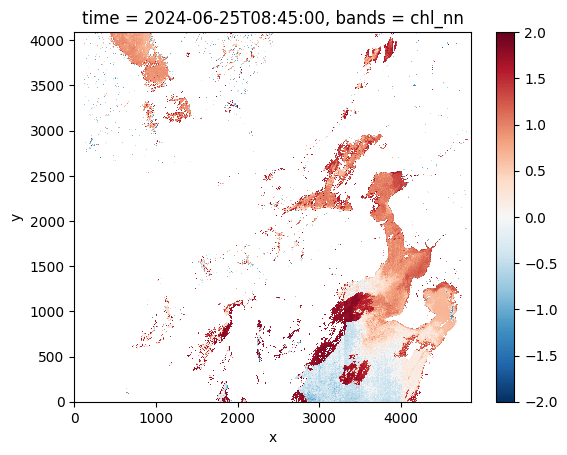

In [3]:
chl.isel(bands=0, time=0).plot()

In [4]:
import matplotlib.pyplot as plt
from pyresample.kd_tree import resample_nearest
from pyresample.geometry import AreaDefinition
import pyresample
import cartopy

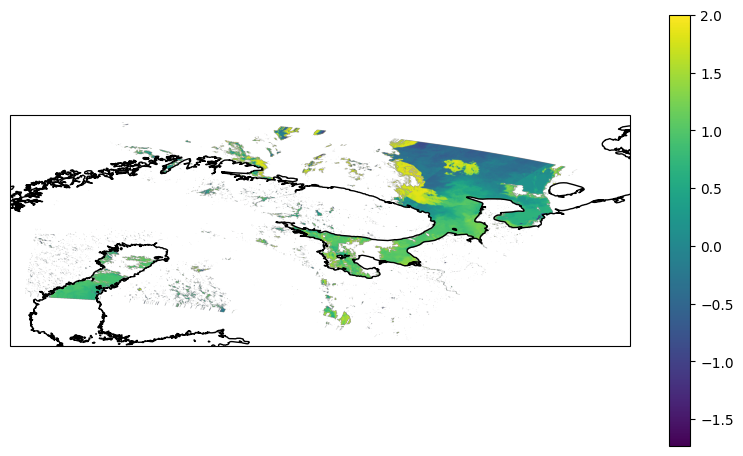

In [6]:
import numpy as np
import xarray as xr
import pyresample
from pyresample.geometry import SwathDefinition, AreaDefinition
from pyresample.kd_tree import resample_nearest
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 1) swath definition (lon/lat arrays)
lons = chl.longitude.values
lats = chl.latitude.values
swath_def = SwathDefinition(lons=lons, lats=lats)

# 2) compute swath bounding box (ignore NaNs)
lon_min = np.nanmin(lons); lon_max = np.nanmax(lons)
lat_min = np.nanmin(lats); lat_max = np.nanmax(lats)

# optional padding (degrees)
pad = 0.2
lon_min -= pad; lon_max += pad
lat_min -= pad; lat_max += pad

# 3) define target area in lon/lat (PlateCarree / EPSG:4326)
# area_extent for lon/lat grids is (min_lon, min_lat, max_lon, max_lat)
area_id = "chl_bbox_ll"
description = "CHL bounding box lon/lat"
proj_id = "longlat"
projection = {"proj": "longlat", "datum": "WGS84"}

# choose output resolution in degrees (roughly 1 km here)
res_deg = 0.01
width  = int(np.ceil((lon_max - lon_min) / res_deg))
height = int(np.ceil((lat_max - lat_min) / res_deg))

area_extent = (lon_min, lat_min, lon_max, lat_max)
area_def = AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

# 4) resample (compute only the band you need)
data = chl.values  # or chl.data.compute() if dask-backed
result = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=np.nan)

# 5) plot in lon/lat
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
im = ax.imshow(
    result,
    origin="upper",
    extent=(lon_min, lon_max, lat_min, lat_max),
    transform=ccrs.PlateCarree(),
)
plt.colorbar(im, ax=ax, shrink=0.7)
plt.show()


NameError: name 'chl' is not defined

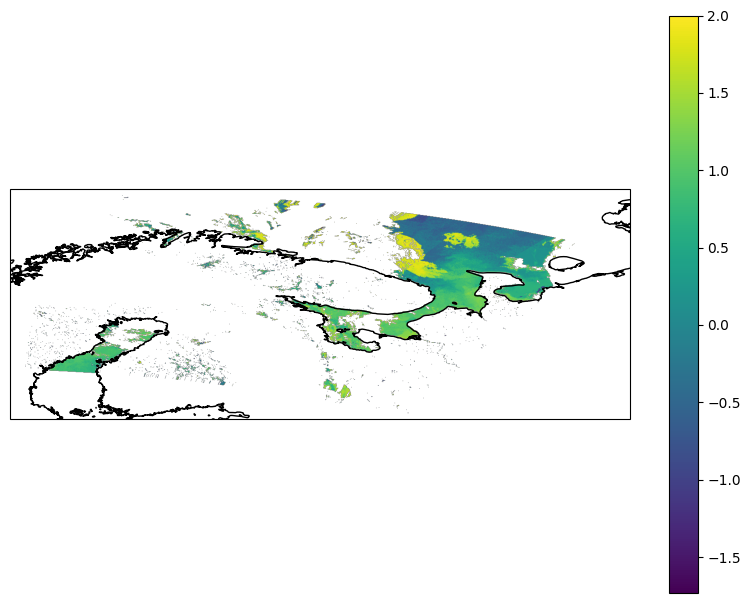

In [17]:
# Option B: EQC (meters) target grid cropped to the CHL swath extent
# - Builds an AreaDefinition whose extent matches the chl swath bbox (with padding)
# - Resamples swath -> cropped EQC grid using nearest-neighbor
# - Plots with Cartopy using the correct projected extent (no global map)

import numpy as np
import matplotlib.pyplot as plt

import pyresample
from pyresample.geometry import SwathDefinition, AreaDefinition
from pyresample.kd_tree import resample_nearest

from pyproj import CRS, Transformer

import cartopy.crs as ccrs


# ----------------------------
# 0) Inputs you already have
# ----------------------------
# Expecting:
#   chl: xarray.DataArray (or similar) with chl.values and lon/lat available as:
#        chl.longitude (2D) and chl.latitude (2D)
#
# If your lon/lat are named differently, change below accordingly.


# ----------------------------
# 1) Build swath definition
# ----------------------------
lons = np.asarray(chl.longitude)
lats = np.asarray(chl.latitude)

swath_def = SwathDefinition(lons=lons, lats=lats)

# Data array (compute if dask-backed)
data = chl.data
try:
    # xarray/dask arrays typically have .compute()
    data = data.compute()
except Exception:
    pass
data = np.asarray(data)


# ----------------------------
# 2) Compute swath bounding box in lon/lat
# ----------------------------
# Ignore NaNs
lon_min = float(np.nanmin(lons))
lon_max = float(np.nanmax(lons))
lat_min = float(np.nanmin(lats))
lat_max = float(np.nanmax(lats))

# Padding in degrees (tweak as needed)
pad_deg = 0.2
lon_min -= pad_deg
lon_max += pad_deg
lat_min -= pad_deg
lat_max += pad_deg

# Clamp to valid lat/lon ranges (safety)
lon_min = max(-180.0, lon_min)
lon_max = min(180.0, lon_max)
lat_min = max(-90.0, lat_min)
lat_max = min(90.0, lat_max)


# ----------------------------
# 3) Define EQC projection + transform bbox to meters
# ----------------------------
# Your EQC projection (Plate Carrée in meters / equirectangular)
projection = {"proj": "eqc", "ellps": "WGS84"}  # PROJ dict (pyresample accepts this)

# Use pyproj to transform lon/lat -> EQC meters
src_crs = CRS.from_epsg(4326)
dst_crs = CRS.from_user_input(projection)  # PROJ dict -> CRS
transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

# Transform all 4 corners of bbox to get safe projected extent
corners_lon = [lon_min, lon_min, lon_max, lon_max]
corners_lat = [lat_min, lat_max, lat_min, lat_max]
xs, ys = transformer.transform(corners_lon, corners_lat)

xmin = float(np.min(xs))
xmax = float(np.max(xs))
ymin = float(np.min(ys))
ymax = float(np.max(ys))

# Optional padding in meters (tweak)
pad_m = 0.0
xmin -= pad_m
xmax += pad_m
ymin -= pad_m
ymax += pad_m


# ----------------------------
# 4) Create cropped AreaDefinition in EQC meters
# ----------------------------
# Choose output resolution in meters (e.g., 3000 m = 3 km)
res_m = 3000.0

width = int(np.ceil((xmax - xmin) / res_m))
height = int(np.ceil((ymax - ymin) / res_m))

# Guard against degenerate sizes
width = max(width, 2)
height = max(height, 2)

area_def = AreaDefinition(
    area_id="chl_bbox_eqc",
    description="CHL bounding box cropped EQC grid",
    proj_id="eqc",
    projection=projection,
    width=width,
    height=height,
    area_extent=(xmin, ymin, xmax, ymax),
)


# ----------------------------
# 5) Resample swath -> cropped EQC area
# ----------------------------
# Radius of influence in meters: pick based on resolution (e.g. 20 km is generous)
roi_m = 20000

result = resample_nearest(
    source_geo_def=swath_def,
    data=data,
    target_geo_def=area_def,
    radius_of_influence=roi_m,
    fill_value=np.nan,
)


# ----------------------------
# 6) Plot with Cartopy (cropped extent, not global)
# ----------------------------
plt.figure(figsize=(10, 10))

crs = area_def.to_cartopy_crs()
ax = plt.axes(projection=crs)
ax.coastlines()

# IMPORTANT: Set extent in the SAME CRS as the axes (EQC meters here)
ax.set_extent((xmin, xmax, ymin, ymax), crs=crs)

# imshow extent must match the area_def extent (meters)
im = ax.imshow(
    result,
    origin="upper",
    extent=(xmin, xmax, ymin, ymax),
    transform=crs,
)

cb = plt.colorbar(im, ax=ax, shrink=0.75)
cb.set_label(getattr(chl, "name", "chl"))

ax.set_title("CHL resampled to cropped EQC grid")
plt.show()


In [9]:
chl_chl_nn.execute()

In [10]:
mask = mask.execute()

In [11]:
chl_nn

<xarray.DataArray (time: 1, bands: 1, y: 4091, x: 4865)> Size: 80MB
dask.array<transpose, shape=(1, 1, 4091, 4865), dtype=float32, chunksize=(1, 1, 4091, 4096), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-06-25T08:45:00
    longitude  (y, x) float64 159MB dask.array<chunksize=(4091, 4096), meta=np.ndarray>
    latitude   (y, x) float64 159MB dask.array<chunksize=(4091, 4096), meta=np.ndarray>
  * bands      (bands) object 8B 'chl_nn'
Dimensions without coordinates: y, x
Attributes:
    history:      Created by pytroll/satpy on 2026-01-13 10:53:32.259731+00:00
    Conventions:  CF-1.7

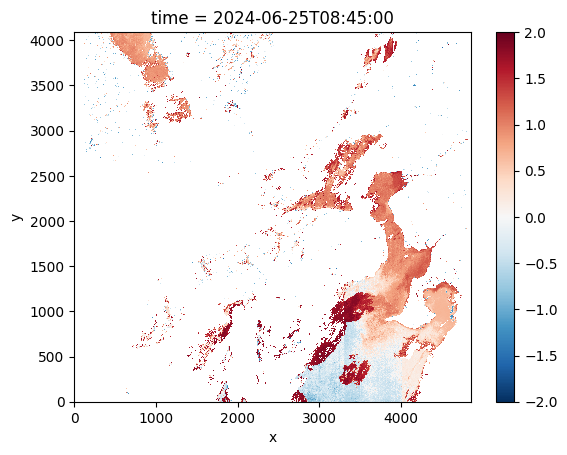

In [15]:
chl_nn.isel(bands=0).where(mask.isel(bands=0)).isel(time=0).plot()

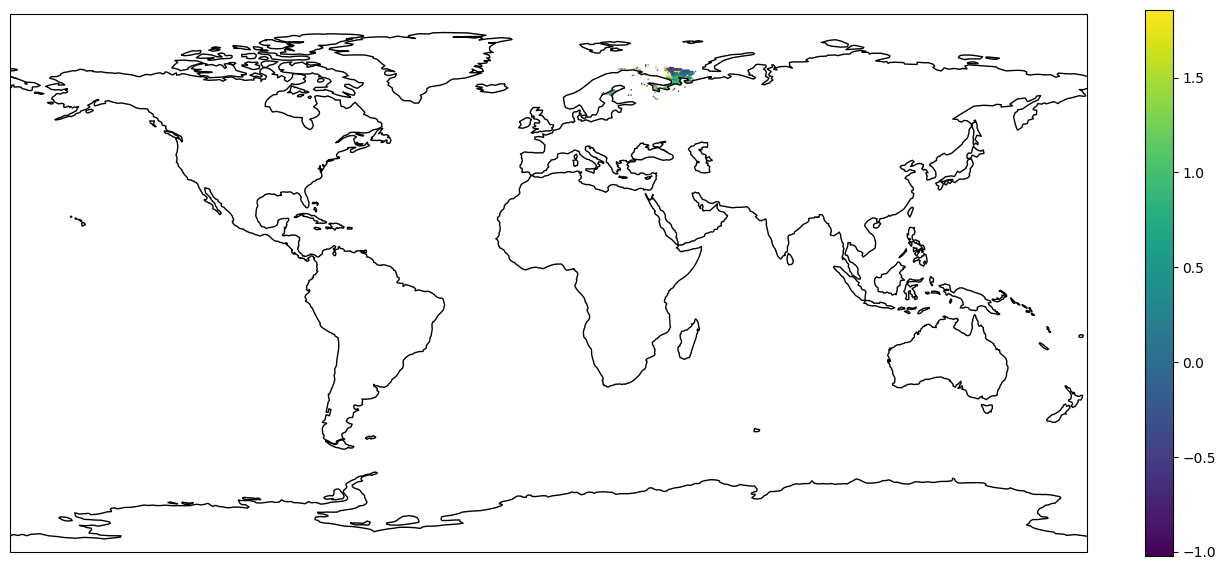

In [5]:
#area definition
area_id = 'worldeqc30km'
description = 'World in 3km, platecarree'
proj_id = 'eqc'
projection = {'proj': 'eqc', 'ellps': 'WGS84'}
width = 820
height = 410
area_extent = (-20037508.3428, -10018754.1714, 20037508.3428, 10018754.1714)
area_def = AreaDefinition(area_id, description, proj_id, projection,
                          width, height, area_extent)

#scene 
#lons, lats = chl_nn.area.get_lonlats()
lons = chl.longitude
lats = chl.latitude
swath_def = pyresample.geometry.SwathDefinition(lons, lats)
result = resample_nearest(swath_def, total_ozone, area_def, radius_of_influence=20000, fill_value=None)

#cartopy
plt.rcParams['figure.figsize'] = [15, 15]
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
coastlines = ax.coastlines()  
ax.set_global()

#plot
img = plt.imshow(result, transform=crs, extent=crs.bounds, origin='upper')
# Calculate (height_of_image / width_of_image)
im_ratio = result.shape[0]/result.shape[1]
 
# Plot vertical colorbar
plt.colorbar(fraction=0.047*im_ratio)
plt.show()

In [ ]:
red = cube.filter_bands("Oa08")
nir = cube.filter_bands("Oa17")

ndvi = (nir - red) / (nir + red)

ndvi = ndvi.reduce_dimension("bands", "first")

ndvi_u8 = ndvi.linear_scale_range(-1, 1, 0, 255)

ndvi_u8

In [ ]:
ndvi = ndvi_u8.execute()
ndvi

In [ ]:
ndvi.isel(time=0).plot()

In [ ]:
import openeo
from openeo_dedl_plugin import register_all
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

register_all()

con = openeo.local.LocalConnection(
    local_collections_path="/home/jovyan/datalake-lab-insula/data"
)

cube = con.load_collection(
    "/home/jovyan/datalake-lab-insula/data/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/", fetch_metadata=True,
)

cube.execute()